## Testing the Permanent Income Hypothesis (PIH) Using Consumption and Income Data

### Abstract
The Permanent Income Hypothesis (PIH), proposed by Milton Friedman, suggests that individuals tend to smooth their consumption over time based on their expected "permanent" income, rather than on temporary fluctuations in currrent income. In this way, temporary changes in income should not lead to significant changes in consumption, so long as their long-term income expectations (on which their spending decisions are based) remain stable. This project tests the PIH by exploring the relationship between consumption and income using time series analysis techniques on aggregate-level data from FRED.

### Outline

Our main objectives will be:
- Investigate the dynamics between income and consumption, testing for Granger causality
- Explore structural breaks, especially around economic crises or major policy changes
- Test for a cointegrating relationship between income and consumption
- Forecast future consumption and income

Key steps and techniques:
1. Data collection

2. Exploratory data analysis
    - Visualise the time series
    - Plot ACFs to detect persistence and seasonality

3. Transform to stationarity
    - Use log-transformed data to stabilise the variance and consider growth-rates
    - Determine order of integration using ADF tests

4. Model selection
    - Select lag lengths using information criteria for AR and ADL models
    
5. Test for Granger causality

6. Test for structural breaks using QLR test

7. Re-evaluate models and forecast

8. Test for cointegration
    - Estimate cointegrating relationship
    - Test for stationarity in residuals

## Data Collection

Before we begin, we need to load the following packages and their dependencies, and clear the environment to ensure that there are no remaining objects or variables that may interfere with out analysis.
- `AER` and `tidyverse` provide useful functions and objects for econometric analysis
- `stargazer` provides well-formatted regression and summary tables for better analysis of models and data
- `quantmod` and `dynlm` for time series analysis
- `urca` for unit root tests
- `forecast` for forecasting using time series models

In [28]:
# Load packages
library(tidyverse)
library(dynlm)
library(stargazer)
library(quantmod)
library(urca)
library(forecast)
library(AER)

# Clear the environment
rm(list = ls())

The next step is to import our data on real disposable personal income and consumption expenditures (DSPIC96 and PCEC96 respectively) from Federal Reserve Economic Data. For this, we will use these datasets from 2007 to present in its quarterly averaged form. This will form our time series data on income and consumption. It is important that this data is real - adjusted for inflation - which is particularly necessary when investigating real changes over time. Dispoable personal income was chosen as it reflects the actual amount that consumers can allocate to consumption or saving, instead of taxes or other government transfers. Personal consumption expenditure was chosen as it encompasses both durable and non-durable goods to better reflect actual consumption.

In [29]:
# Import data
DSPIC96 <- read.csv("DSPIC96.csv")
PCEC96 <- read.csv(("PCEC96.csv"))

We will convert this data into both a dataframe with quarterly data, as well as individual `xts` objects for easier data handling. Here we also ensure that any `NA` values are omitted from the dataframe and we can verify this (along with checking other basic statistics) by using the `summary()` function

In [52]:
# Create dataframe for easier data handling
data <- na.omit(data.frame(date = as.Date(DSPIC96$DATE),
                           income = as.numeric(DSPIC96$DSPIC96),
                           consumpt = as.numeric(PCEC96$PCEC96)))
data$quarterly <- as.yearqtr(data$date)
head(data)
summary(data)

# Data as xts objects
income <- xts(data$income, data$quarterly)
consumpt <- xts(data$consumpt, data$quarterly)

,date,income,consumpt,quarterly
,<date>,<dbl>,<dbl>,<yearqtr>
1,2007-01-01,11995.90,11183.30,2007 Q1
2,2007-04-01,12055.33,11212.67,2007 Q2
3,2007-07-01,12075.63,11287.43,2007 Q3
4,2007-10-01,12090.33,11331.97,2007 Q4
5,2008-01-01,12141.60,11316.40,2008 Q1
6,2008-04-01,12391.20,11347.60,2008 Q2


      date                income         consumpt       quarterly   
 Min.   :2007-01-01   Min.   :11996   Min.   :11076   Min.   :2007  
 1st Qu.:2011-04-23   1st Qu.:12764   1st Qu.:11518   1st Qu.:2011  
 Median :2015-08-16   Median :13977   Median :12680   Median :2016  
 Mean   :2015-08-16   Mean   :14278   Mean   :12882   Mean   :2016  
 3rd Qu.:2019-12-09   3rd Qu.:15798   3rd Qu.:13863   3rd Qu.:2020  
 Max.   :2024-04-01   Max.   :18378   Max.   :15755   Max.   :2024  

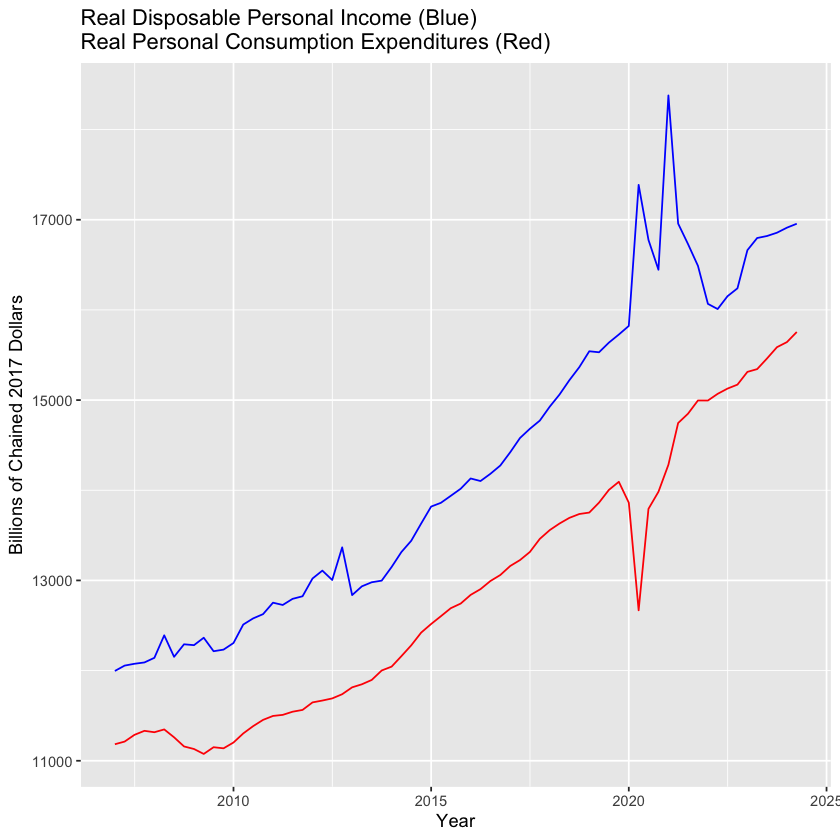

In [31]:
# Plot data as time series
ggplot(data, aes(x = date)) +
  geom_line(mapping = aes(y = income), color = "blue") +
  geom_line(mapping = aes(y = consumpt), color = "red") +
  labs(title = "Real Disposable Personal Income (Blue)\nReal Personal Consumption Expenditures (Red)",
       x = "Year", y = "Billions of Chained 2017 Dollars")

## Exploratory Data Analysis

By plotting both income and consumption, we can observe both the evidence of non-stationarity as well as exponential growth. In order to reduce heteroskedasticity and stabilise the variance, we will take a log-transformation of the data. Additionally, we will create `xts` objects for the first difference of the log-transformed data. We will plot the log transformed data along with its first difference below it, and use 'eyeball econometrics' to see whether differencing the data once transforms it to stationarity.

Because we are using quarterly data, we multiply the difference by 400 so that it takes the form of an annualised percentage growth rate
- Difference of logs: $\Delta\ log\ Y_t := log\ Y_t - log\ Y_{t-1}$
- Annualised % growth rate for quarterly data: $400 \times \Delta\ log\ Y_t$

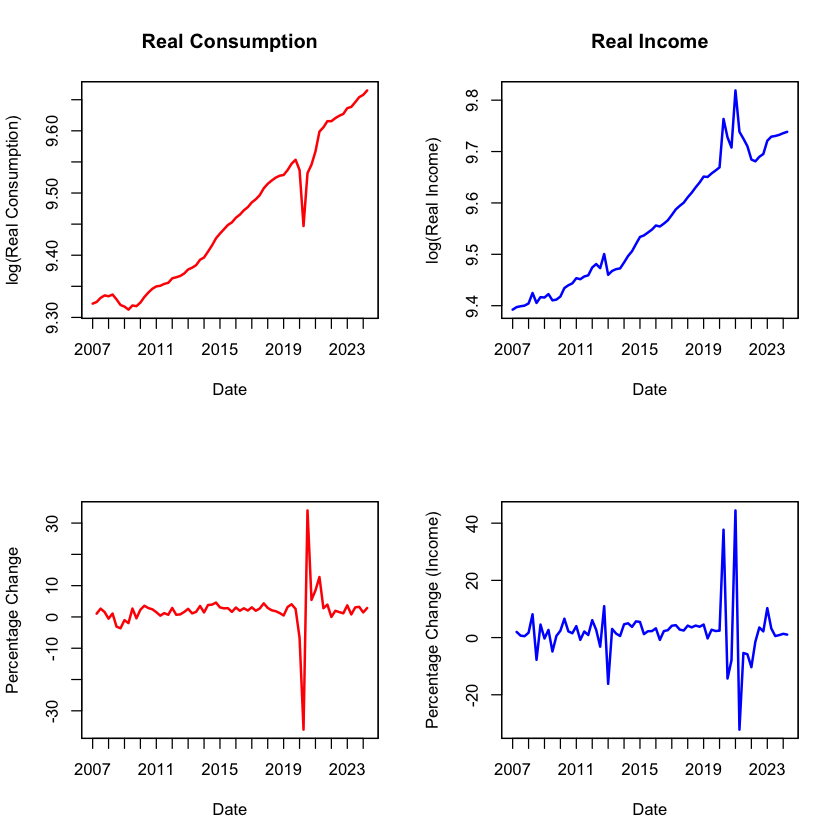

In [32]:
#First differences as xts objects
inc_diff <- 400 * log(income / lag(income))
con_diff <- 400 * log(consumpt / lag(consumpt))

# Plot log values and first differences
par(mfrow = c(2,2)) # Split plot frame into four

plot(as.zoo(log(consumpt)), xaxt = "n",
     xlab = "Date",
     ylab = "log(Real Consumption)",
     main = "Real Consumption",
     col = "red",
     lwd = 2)
axis(1, at = seq(2007, 2024.25, 1)) # Remove overcrowded x-axis and then replace

plot(as.zoo(log(income)), xaxt = "n",
     xlab = "Date",
     ylab = "log(Real Income)",
     main = "Real Income",
     col = "blue",
     lwd = 2)
axis(1, at = seq(2007, 2024.25, 1))

plot(as.zoo(con_diff), xaxt = "n",
     xlab = "Date",
     ylab = "Percentage Change",
     col = "red",
     lwd = 2)
axis(1, at = seq(2007, 2024.25, 1))

plot(as.zoo(inc_diff), xaxt = "n",
     xlab = "Date",
     ylab = "Percentage Change (Income)",
     col = "blue",
     lwd = 2)
axis(1, at = seq(2007, 2024.25, 1))

The first differenced series' both appear to be weakly stationary with constant means that are slightly positive, along with a relatively constant variance. There does, however, appear to be a structural break from the shock of the COVID-19 pandemic, and possibly from the recovery period of the Great Recession, particularly in the income time series.

To further verify the degree of stationarity of the differenced seriess, we can plot the sample ACFs for each series. From this we can see that the log-transformed series' exhibit a high degree of persistence, whilst the differenced series' are very weakly persistent, which is consistent with stationary and non-stationary series respectively. Although this is not a necessary condition, it is still a useful heuristic. The dashed lines represent the interval that contains $\widehat{ρ}_h$ (sample autocorrelation estimator) with 95% probability,
assuming an i.i.d. (i.e. uncorrelated) series.

However, it is worth noting that we can already see that the consumption time series exhibits very weak serial correlation which suggests that we will struggle to fit an AR model.

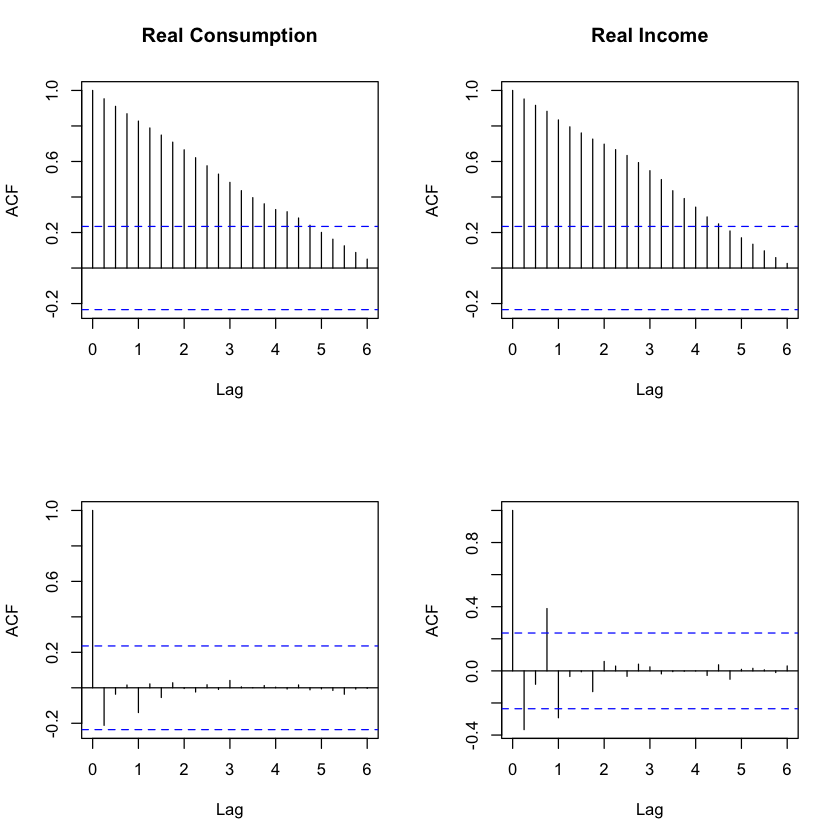

In [33]:
# Autocorrelation functions
par(mfrow = c(2,2))

acf(na.omit(log(consumpt)), lag.max = 24,
    plot = TRUE, main = "Real Consumption")
acf(na.omit(log(income)), lag.max = 24,
    plot = TRUE, main = "Real Income")
acf(na.omit(con_diff), lag.max = 24,
    plot = TRUE, main = "")
acf(na.omit(inc_diff), lag.max = 24,
    plot = TRUE, main = "")

## Determining the Order of Integration

We can conduct a formal test for stationarity by carrying out an Augmented Dickey-Fuller (ADF) test for the presence of a unit root in the time series. This will also enable us to determine the order of integration of each time series through iteratively differencing and performing ADF tests until stationarity is reached.

For a given time series ${Y_t}$, the corresponding ADF test is carried out on the following regression:
$$\Delta Y_t = \beta _0 + \alpha t + \delta Y_{t-1} + \sum _{i=1}^{p} \gamma _1 \Delta Y_{t-i} + u_t$$

Where $\alpha t$ is a trend term that can be excluded for a more powerful constant-only test.  
The ADF test has a null hypothesis $H_0: \delta = 0$ and an alternative hypothesis $H_1: \delta < 0$
- Null: {$\Delta Y_t$} is AR(p), {$Y_t$} has a unit root
- Alternative: {$Y_t$} is trend stationary AR(p + 1)

Decision rule: reject if $t < c_\alpha$  
Critical values: from tabulation below (taken from Stock and Watson)


|Left-tail critical value | 10% | 5% | 1%|
| ------------------------|---- | ---|---|
|N[0, 1] |−1.28 |−1.64 |−2.33|
|$DF_{cn}$: constant only |−2.57 |−2.86 |−3.43|
|$DF_{tr}$: constant and trend |−3.21 |−3.41 |−3.96|

First we construct a function that returns 'p' - the number of parameters in the inputted model; the associated BIC and AIC (for model selection); and 't' - the test statistic for the for the ADF test. It is worth noting that the model returns the test statistic on the coefficient of the second variable within the inputted model, so ensure that any model which includes a trend term is as follows: $\Delta Y_t = \beta _0 + \delta Y_{t-1} + \alpha t + \sum _{i=1}^{p} \gamma _1 \Delta Y_{t-i} + u_t$  
Also note that the trend term is counted as a parameter by the ADF function we created, so remember to minus one to take into account the total number of RHS lags.

In [34]:
#ADF t-stat function for AR models of class 'dynlm'
ADF <- function(model) {
  
  ssr <- sum(model$residuals^2)
  t <- length(model$residuals)
  npar<- length(model$coef)
  tstat <- summary(model)$coef[2, "t value"]
  
  return(
    round(c("p" = npar - 1,
            "AIC" = log(ssr/t) + npar * (2/t),
            "BIC" = log(ssr/t) + npar * log(t)/t,
            "t" = tstat), 4)
  )
}

# Test for unit root and order of integration using ADF function
# For log(income)
ADF_income_trend <- sapply(1:8, function(x)
  "UR" = ADF(dynlm(diff(log(ts(income))) ~ L(log(ts(income))) + 
                     trend(log(ts(income)), scale = F) + 
                     diff(L(log(ts(income)),1:x)))))
stargazer(ADF_income_trend, type = "text", title = "Income ADF")

# For first difference of log(income)
ADF_income_const <- sapply(1:8, function(x)
  "UR" = ADF(dynlm(diff(ts(inc_diff)) ~ L(ts(inc_diff)) +
                     diff(L(ts(inc_diff),1:x)))))
stargazer(ADF_income_const, type = "text", title = "Inc Diff ADF")

# For log(consumpt)
ADF_consumpt_trend <- sapply(1:8, function(x)
  "UR" = ADF(dynlm(diff(log(ts(consumpt))) ~ L(log(ts(consumpt))) + 
                     trend(log(ts(consumpt)), scale = F) + 
                     diff(L(log(ts(consumpt)),1:x)))))
stargazer(ADF_consumpt_trend, type = "text", title = "Consumpt ADF")

# For first difference of log(consumpt)
ADF_consumpt_const <- sapply(1:8, function(x)
  "UR" = ADF(dynlm(diff(ts(con_diff)) ~ L(ts(con_diff)) +
                     diff(L(ts(con_diff),1:x)))))
stargazer(ADF_consumpt_const, type = "text", title = "Con Diff ADF")



Income ADF
p     3      4      5      6      7      8      9      10  
AIC -7.670 -7.658 -7.781 -7.740 -7.721 -7.711 -7.670 -7.621
BIC -7.539 -7.494 -7.582 -7.505 -7.451 -7.405 -7.327 -7.241
t   -2.573 -2.077 -2.893 -2.895 -2.901 -2.134 -1.863 -1.774
-----------------------------------------------------------

Inc Diff ADF
p     2      3      4      5      6      7      8      9   
AIC 4.333  4.272  4.317  4.340  4.289  4.313  4.357  4.385 
BIC 4.432  4.404  4.484  4.543  4.527  4.588  4.669  4.734 
t   -8.549 -4.136 -3.793 -3.792 -4.518 -4.487 -3.788 -2.791
-----------------------------------------------------------

Consumpt ADF
p     3      4      5      6      7      8      9      10  
AIC -8.309 -8.284 -8.263 -8.241 -8.217 -8.179 -8.129 -8.079
BIC -8.178 -8.120 -8.064 -8.007 -7.947 -7.873 -7.786 -7.698
t   -2.906 -2.966 -3.190 -3.061 -3.209 -3.068 -2.870 -2.701
-----------------------------------------------------------

Con Diff ADF
p     2      3      4      5      6      7    

From these ADF tests we find:
- We fail to reject the null of a unit root in income and consumption at the 10% level, and is robust out to eight additional lags
- We reject the null of a unit root in their first difference at the 1% level out to seven additional lags

Therefore, we conclude that $Y_t$ ~ $I(1)$ and $X_t$ ~ $I(0)$ - that is, both series are integrated of order one.

There is also a helpful function `ur.df` within the package `urca` that can carry out an ADF test for us without having to specify the regression model. Here, we can choose how many additional lags we wish to include (`lags =`), and whether we wish the function to automatically select the number of lags by setting `selectlags =` to an an information criterion (e.g. AIC), or to simply use our given lags as shown below. It not only provides the test-statistic, but also the associated critical values in the "tau" row.

In [35]:
# Income
summary(ur.df(log(income),
              type = "trend",
              lags = 3,
              selectlags = "Fixed"))

#Inc Diff
summary(ur.df(na.omit(inc_diff),
              type = "drift",
              lags = 2,
              selectlags = "Fixed"))

# Consumpt
summary(ur.df(log(consumpt),
              type = "trend",
              lags = 1,
              selectlags = "Fixed"))

#Con Diff
summary(ur.df(na.omit(con_diff),
              type = "drift",
              lags = 1,
              selectlags = "Fixed"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.054708 -0.006670 -0.000474  0.003974  0.090738 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.6383541  0.9100570   2.899  0.00522 **
z.lag.1     -0.2818337  0.0974222  -2.893  0.00531 **
tt           0.0016711  0.0005888   2.838  0.00618 **
z.diff.lag1 -0.1861053  0.1326724  -1.403  0.16585   
z.diff.lag2  0.0260819  0.1310496   0.199  0.84292   
z.diff.lag3  0.3924065  0.1175627   3.338  0.00145 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01957 on 60 degrees of freedom
Multiple R-squared:  0.3608,	Adjusted R-squared:  0.3075 
F-statistic: 6.772 on 5 and 60 DF,  p-value: 4.582e-05


Value of test-stati


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.801  -2.375  -0.086   3.034  35.611 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.3858     1.1638   2.050 0.044601 *  
z.lag.1      -1.1662     0.2819  -4.137 0.000108 ***
z.diff.lag1  -0.2127     0.2107  -1.009 0.316742    
z.diff.lag2  -0.3183     0.1204  -2.644 0.010364 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.22 on 62 degrees of freedom
Multiple R-squared:  0.7336,	Adjusted R-squared:  0.7207 
F-statistic:  56.9 on 3 and 62 DF,  p-value: < 2.2e-16


Value of test-statistic is: -4.1365 8.5553 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.51 -2.89 -2.58
phi1  6.70  4.71  3.86



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.102788 -0.002147  0.000648  0.003368  0.040408 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.2295570  0.7666369   2.908  0.00499 **
z.lag.1     -0.2404444  0.0827521  -2.906  0.00503 **
tt           0.0014017  0.0004529   3.095  0.00292 **
z.diff.lag  -0.1209466  0.1201450  -1.007  0.31788   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01525 on 64 degrees of freedom
Multiple R-squared:  0.1729,	Adjusted R-squared:  0.1342 
F-statistic: 4.461 on 3 and 64 DF,  p-value: 0.00659


Value of test-statistic is: -2.9056 6.5657 4.9549 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.935  -0.898   0.242   1.303  22.592 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.61516    0.88609   2.951  0.00442 ** 
z.lag.1     -1.31427    0.19390  -6.778 4.55e-09 ***
z.diff.lag   0.08466    0.12455   0.680  0.49911    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.533 on 64 degrees of freedom
Multiple R-squared:  0.6086,	Adjusted R-squared:  0.5964 
F-statistic: 49.77 on 2 and 64 DF,  p-value: 9.172e-14


Value of test-statistic is: -6.7782 22.9722 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.51 -2.89 -2.58
phi1  6.70  4.71  3.86


## Model Selection

Now that we have stationary data to work with, we can start to fit different models in order to find the best match. In this project, we will consider both autoregressive models of order p - AR(p) - and autoregressive distributed lag models of order (p,q) - ADL(p,q). Therefore, we will need to select the number of lags, p, that we include within our model.

This is a tradeoff because a larger number of lags means:
- Less 'bias' in the approximation of our optimal forecast
- More parameters that can be optimised, and a more flexible model

But it also means:
- More 'variance' in the estimation of the model parameters
- More parameters that must be estimated, using the same amount of data

Thus, we do not wish to include unnecessary lags. The selection can be made using a step-wise 'testing down' procedure, starting with a large model and removing lags until a statistically significant non-zero coefficient lag is reached via hypothesis testing. However, this does not consider more parsimonious models and allows for 'chance' large models.  
Alternatively, we can use information criteria (IC) that formulate the bias-variance tradeoff, and select a model that minimises a given IC. Two examples of this are the Akaike IC (AIC) and the Bayesian IC (BIC):

$$AIC_m\ :=\ log\ \frac {SSR_m}T\ +\ m\ \frac 2 T$$
$$BIC_m\ :=\ log\ \frac {SSR_m}T\ +\ m\ \frac {log\ T} T$$
Where $m$ refers to the number of parameters (including the intercept), and $T$ refers to the number of observations.

Here, the BIC penalises larger models more and thus the BIC can be shown to be consistent (chooses the true order $p_0$ with high probability in large samples), whilst the AIC tends to be conservative (may choose a slightly larger $p$). When compared to standard regression diagnostics such as $R^2$ or the standard error of the regression (SER), these ICs choose models with stronger forecasting performance. This is because $R^2$ always favours larger models, and the SER penalises additional parameters too little as:

$$2\ log\ SER_m\ \simeq\ log\ \frac {SSR_m} {T}\ +\ m\ \frac {1} {T}$$

To start, we create a function that returns 'p' - the number of parameters in the model (excluding the intercept); 'SER*' - 2 log SER; the AIC and BIC; and '|t|' - the magnitude of the test statistic associated with a test that the last coefficient is equal to zero. Thus, we can select the lag order of a given model using the BIC or AIC, and compare to the results from a step-wise procedure and from using the SER.

In [36]:
# Information criteria function for AR models of class 'dynlm'
IC <- function(model) {

  ssr <- sum(model$residuals^2)
  t <- length(model$residuals)
  npar <- length(model$coef)
  ser <- summary(model)$sigma
  tstat <- abs(summary(model)$coef[length(model$coef), "t value"])

  return(
    round(c("p" = npar - 1,
            "SER*" = 2 * log(ser),
            "AIC" = log(ssr/t) + npar * (2/t),
            "BIC" = log(ssr/t) + npar * log(t)/t,
            "|t stat|" = tstat), 4)
  )
}

# Lag length selection using IC function
IC_con <- sapply(1:10, function(x)
  "AR" = IC(dynlm(ts(con_diff) ~ L(ts(con_diff), 1:x))))
IC_inc <- sapply(1:10, function(x)
  "AR" = IC(dynlm(ts(inc_diff) ~ L(ts(inc_diff), 1:x))))

stargazer(IC_con, type = "text", title = "IC Con")
stargazer(IC_inc, type = "text", title = "IC Inc")


IC Con
p           1     2     3     4     5     6     7     8     9    10  
SER*      3.730 3.754 3.785 3.793 3.824 3.839 3.853 3.875 3.892 3.926
AIC       3.759 3.797 3.844 3.867 3.913 3.944 3.973 4.011 4.043 4.092
BIC       3.824 3.896 3.977 4.034 4.115 4.182 4.248 4.322 4.392 4.480
| t stat| 1.761 0.680 0.089 1.174 0.351 0.653 0.093 0.270 0.340 0.198
---------------------------------------------------------------------

IC Inc
p           1     2     3     4     5     6     7     8     9    10  
SER*      4.324 4.289 4.213 4.243 4.251 4.185 4.193 4.222 4.234 4.256
AIC       4.353 4.333 4.272 4.317 4.340 4.289 4.313 4.357 4.385 4.423
BIC       4.418 4.432 4.404 4.484 4.543 4.527 4.588 4.669 4.734 4.810
| t stat| 3.198 2.078 2.644 0.396 0.973 2.275 1.228 0.016 1.122 0.412
---------------------------------------------------------------------


From here, we can compare the results of our different lag order selection processes. For consumption, we see that the SER*, AIC, and BIC are all minimised when the lag order is one. However, the test statistic reveals that the coefficient on an AR(1) process for consumption is not significant at the 5% level. Therefore, the evidence suggests that consumption does not follow an AR(p) process. Instead, a test for the intercept on an intercept-only model reveals that this is the only model that is significant for consumption. Thus we cannot accurately model consumption as an AR(p) process. This does not seem to be in conflict with the PIH as it seems that consumption is roughly constant and not affected by other exogenous changes, at least viewed through the lens of an AR model.

In contrast, the first, second, third, and sixth lags for income are statistically significant at the 5% level. Additionally, SER* is minimised when p equals six. Therefore, both a step-wise procedure and using the SER* would lead to the selection of an AR(6) process. However, boh the AIC and BIC are minimised when p equals three, leading to the selection of a more parsimonious AR(3) process. Here we can see the benefit on relying on ICs for model selection.

Instead of reading through the tables and manually looking for the minimum values, we can use the following code to extract it automatically:

In [37]:
IC_con[, which.min(IC_con[2, ])] # min SER*
IC_con[, which.min(IC_con[3, ])] # min AIC
IC_con[, which.min(IC_con[4, ])] # min BIC

IC_inc[, which.min(IC_inc[2, ])]
IC_inc[, which.min(IC_inc[3, ])]
IC_inc[, which.min(IC_inc[4, ])]

p     SER*      AIC      BIC |t stat| 
  1.0000   3.7303   3.7592   3.8245   1.7609

p     SER*      AIC      BIC |t stat| 
  1.0000   3.7303   3.7592   3.8245   1.7609

p     SER*      AIC      BIC |t stat| 
  1.0000   3.7303   3.7592   3.8245   1.7609

p     SER*      AIC      BIC |t stat| 
  6.0000   4.1848   4.2892   4.5273   2.2749

p     SER*      AIC      BIC |t stat| 
  3.0000   4.2130   4.2717   4.4044   2.6440

p     SER*      AIC      BIC |t stat| 
  3.0000   4.2130   4.2717   4.4044   2.6440

We can then repeat the same process for ADL(p,q) models of consumption and income, setting p = q to reduce the set of models in consideration to a reasonable amount. Do note that the value for 'p' that the function returns will need to be divided by two in order to obtain the correct value for an ADL(p,p) model, as the function simply returns the number of parameters excluding the intercept.

In [38]:
IC_con_adl <- sapply(1:10, function(x)
  "ADL" = IC(dynlm(ts(con_diff) ~ L(ts(con_diff),1:x) + L(ts(inc_diff),1:x))))
stargazer(IC_con_adl, type = "text", title = "IC Con ADL")
con_adl <- dynlm(ts(con_diff) ~ L(ts(con_diff)) + L(ts(inc_diff)))
summary(con_adl)

IC_inc_adl <- sapply(1:10, function(x)
  "ADL" = IC(dynlm(ts(inc_diff) ~ L(ts(inc_diff),1:x) + L(ts(con_diff),1:x))))
stargazer(IC_inc_adl, type = "text", title = "IC Inc ADL")
inc_adl <- dynlm(ts(inc_diff) ~ L(ts(inc_diff),1:3) + L(ts(con_diff),1:3))
summary(inc_adl)


IC Con ADL
p           2     4     6     8    10    12    14    16    18    20  
SER*      3.642 3.664 3.674 3.707 3.751 3.754 3.813 3.866 3.899 3.970
AIC       3.685 3.736 3.774 3.835 3.906 3.935 4.020 4.096 4.152 4.242
BIC       3.783 3.900 4.006 4.136 4.278 4.378 4.534 4.685 4.815 4.981
| t stat| 2.670 1.201 0.759 0.393 0.558 0.640 0.098 0.673 0.108 0.105
---------------------------------------------------------------------



Time series regression with "ts" data:
Start = 3, End = 70

Call:
dynlm(formula = ts(con_diff) ~ L(ts(con_diff)) + L(ts(inc_diff)))

Residuals:
    Min      1Q  Median      3Q     Max 
-38.504  -0.763   0.200   1.107  21.488 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)      1.59094    0.84191   1.890  0.06326 . 
L(ts(con_diff)) -0.04542    0.13087  -0.347  0.72966   
L(ts(inc_diff))  0.24722    0.09261   2.670  0.00958 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.176 on 65 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1392,	Adjusted R-squared:  0.1128 
F-statistic: 5.257 on 2 and 65 DF,  p-value: 0.007649



IC Inc ADL
p           2     4     6     8    10    12    14    16    18    20  
SER*      4.272 4.149 3.817 3.820 3.807 3.755 3.789 3.850 3.900 3.903
AIC       4.316 4.221 3.917 3.948 3.962 3.936 3.996 4.080 4.153 4.175
BIC       4.413 4.385 4.149 4.249 4.334 4.378 4.511 4.669 4.816 4.915
| t stat| 2.121 2.910 4.489 1.655 0.700 1.989 0.219 0.391 0.119 0.264
---------------------------------------------------------------------



Time series regression with "ts" data:
Start = 5, End = 70

Call:
dynlm(formula = ts(inc_diff) ~ L(ts(inc_diff), 1:3) + L(ts(con_diff), 
    1:3))

Residuals:
    Min      1Q  Median      3Q     Max 
-17.152  -1.892  -0.116   2.425  36.061 

Coefficients:
                                            Estimate Std. Error t value
(Intercept)                                 3.214099   1.155831   2.781
L(ts(inc_diff), 1:3)zoo(coredata(x), tt).1 -0.173626   0.120095  -1.446
L(ts(inc_diff), 1:3)zoo(coredata(x), tt).2  0.006273   0.120168   0.052
L(ts(inc_diff), 1:3)zoo(coredata(x), tt).3  0.024492   0.114779   0.213
L(ts(con_diff), 1:3)zoo(coredata(x), tt).1 -0.110733   0.153000  -0.724
L(ts(con_diff), 1:3)zoo(coredata(x), tt).2  0.393589   0.153013   2.572
L(ts(con_diff), 1:3)zoo(coredata(x), tt).3 -0.733266   0.163334  -4.489
                                           Pr(>|t|)    
(Intercept)                                 0.00727 ** 
L(ts(inc_diff), 1:3)zoo(coredata(x), tt).1  0.15354    

From this, we can see a very similar story to the lag selection for AR(p) models. This gives us consumption as an ADL(1,1) model, and income as an ADL(3,3) model. However, the coefficients for most lags are not statistically significant on either model. Despite this, we will carry out a test for Granger causality to check whether including lags of the other variable improves forecasting performance.

## Granger Causality

We start by creating a function for objects of class `dynlm` that will return the F statistic for a hypothesis test with a null of non-Granger causality (i.e. that the coefficient for all the lags of the other time series are equal to zero) and its associated p-value.

In [39]:
# Granger Causality F test function
Granger <- function(model) {
  
  npar <- length(model$coefficients)-1
  startindex <- (length(model$coef) + 1) / 2
  coefnames <- names(model$coef)[-(1:startindex)] # Parameter names excluded from restricted model
  Fstat <- linearHypothesis(model,
                            c(coefnames),
                            vcov. = sandwich)$F[2]
  pval <- linearHypothesis(model,
                           c(coefnames),
                           vcov. = sandwich)$`Pr(>F)`[2]
  
  return(round(
    c("p" = npar/2,
      "F" = Fstat,
      "p-value" = pval),4)
  )
}

# F test for income Granger-causing consumption
granger_con <- sapply(1:10, function(x)
  "GT" = Granger(dynlm(ts(con_diff) ~ L(ts(con_diff), 1:x) + L(ts(inc_diff), 1:x))))
stargazer(granger_con, type = "text", title = "Granger Con")

# F test for consumption Granger-causing income
granger_inc <- sapply(1:10, function(x)
  "GT" = Granger(dynlm(ts(inc_diff) ~ L(ts(inc_diff), 1:x) + L(ts(con_diff), 1:x))))
stargazer(granger_inc, type = "text", title = "Granger Inc")



Granger Con
p         1     2     3     4     5     6     7     8     9    10  
F       6.767 6.204 2.887 1.907 1.876 1.714 1.399 1.319 1.332 1.134
p-value 0.012 0.004 0.043 0.122 0.114 0.137 0.228 0.259 0.251 0.364
-------------------------------------------------------------------

Granger Inc
p         1     2     3      4      5      6      7      8      9      10  
F       2.574 1.757 21.970 24.062 19.926 34.548 29.918 23.530 17.330 17.564
p-value 0.114 0.181   0      0      0      0      0      0      0      0   
---------------------------------------------------------------------------


From this, we reject the null hypothesis that income does not Granger-cause consumption at the 5% level, but this only extends to three lags. Additionally, we must remember that an ADL model is not a good fit for forecasting consumption, therefore, there is not sufficient evidence to come to a strong conclusion. The permanent income hypothesis would suggest that income should not Granger-cause consumption - information about temporary changes in income should not improve our ability to forecast consumption as consumers should base consumption on long-term income. Although there are some criticisms of the PIH, particularly with respect to constraints facing low permanent income households (e.g. credit constraints), this should not appear as strongly with aggregate level data here. Considering the fact that annualised percentage changes in log consumption is best fit by an intercept-only model; the failure of fitting an ADL model; and the lack of robust-ness out to longer lags in a test for Granger-causality, we fail to reject this aspect of the PIH.

When we consider the results from the test for consumption Granger-causing income, we find strong evidence of Granger causality. Here, we reject the null hypothesis whenever p is greater than two, and there is an overwheming rejection when p equals three (the model chosen by both the AIC and BIC). The PIH does not necessarily provide any commentary on why this might be the case, but this could be due to the forward-looking behaviour of consumers which forms an essential part of the PIH. As consumers base their consumption on their expected long-term permanent income, they make adjustments in their predictions of their permanent income. Thus, consumption may appear to lead income because changes to consumers' quarterly income simply verifies their new expectations after exogenous changes.  
There may also be other explanations unrelated to the PIH such as due to real business cycles, however, it is also important to point out that such an outcome is not necessarily unexpected. The PIH does suggest that there is a long-run relationship between consumption and income, meaning that they should share a common stochastic trend and have a long-run equilibrium. Thus, it predicts that there is a cointegrating relationship between consumption and income. Cointegration implies Granger causality in at least one direction. Therefore, because the PIH predicts that income should not Granger-cause consumption, we expect that consumption should Granger-cause income. As a result, we will be testing for cointegration later in this project.

## Structural Breaks

From the time series plots of both consumption and income during our exploratory data analysis, we saw that there may be parameter instability surrounding the COVID-19 pandemic and the Great Recession. Therefore, we should perform a test for structural breaks within each time series to ensure stationarity. This will also be useful in investigating whether there is evidence for these crises having a statistically significant effect on income and consumption. Do note that there may be some difficulty in testing due to the fact that both events occurred towards beginning and end of our sample.

To test for a break, we will be using a Quandt likelihood ratio (QLR) test. The QLR test statistic is the largest Chow test statistic (F test for the null hypothesis that the coefficient for all breakpoint dummies are equal to zero) over the range of break dates selected. Stock and Watson provide critical values for a QLR test with a 15% trimming parameter (testing over the central 70% of the sample) which is a reasonable value that includes the COVID-19 period, therefore this is the trimming parameter that we will use. Thus, we first find the indices that correspond to the start and end of the central 70% of the sample (rounded to the nearest whole number), and create a variable for this range of dates. We then create empty vectors for the Chow test statistics, loop over the range of dates to perform the QLR test, and then obtain the QLR test statistic and its corresponding date. 

We start with a QLR break test for consumption, using both an intercept only model and an AR(1) model.

In [40]:
# Find start and end index for a 15% trimming parameter
0.15 * length(con_diff) # 10.5
0.85 * length(con_diff) # 59.5

con_diff[11] # 2009 Q3
con_diff[60] # 2021 Q4

# Define tau for 2009 Q3 to 2021 Q4
tau <- seq(2009.50, 2021.75, 0.25)

# Initialise vector of F-stats for QLR tests
Fstats_break_con_int <- numeric(length(tau))
Fstats_break_con_ar1 <- numeric(length(tau))
Fstats_break_inc <- numeric(length(tau)) # For income later

# QLR test for consumption using both AR1 and intercept-only models
for (i in 1:length(tau)) {
  
  D <- time(con_diff) > tau[i]
  
  breaktest <- dynlm(ts(con_diff) ~ 1 + D*1)
  
  Fstats_break_con_int[i] <- linearHypothesis(breaktest,
                                        c("DTRUE=0"),
                                        vcov. = sandwich)$F[2]
}

for (i in 1:length(tau)) {
  
  D <- time(con_diff) > tau[i]
  
  breaktest <- dynlm(ts(con_diff) ~ L(ts(con_diff)) + D*L(ts(con_diff)))
  
  Fstats_break_con_ar1[i] <- linearHypothesis(breaktest,
                                        c("DTRUE=0",
                                          "L(ts(con_diff)):DTRUE"),
                                        vcov. = sandwich)$F[2]
}

QLR_con_int <- max(Fstats_break_con_int) # QLR statistic
QLR_con_int
as.yearqtr(tau[which.max(Fstats_break_con_int)]) # Corresponding break date estimator

QLR_con_ar1 <- max(Fstats_break_con_ar1)
QLR_con_ar1
as.yearqtr(tau[which.max(Fstats_break_con_ar1)])


[1] 10.5

[1] 59.5

            [,1]
2009 Q3 2.681558

            [,1]
2021 Q4 3.935997

[1] 5.319759

[1] "2009 Q4"

[1] 5.570082

[1] "2020 Q2"

The critical values for the first test with one restriction are 7.12 at the 10% level, and 8.68 at the 5% level. As 5.32 is less than 7.12, this means that we fail to reject the null hypothesis that the coefficient on the breakpoint dummy is equal to zero (i.e. that there is no break).

The critical values for the second test with two restrictions are 5.00 at the 10% level, and 5.86 at the 5% level. This means that we reject the null hypothesis at the 10% level, but not the 5% level, which means that there is more evidence for a break under an AR(1) model of consumption change. However, we did not previously find much support for modelling consumption with an AR(1) model, therefore we cannot conclude that there is evidence for a break within consumption during the period under study. However, it is interesting to note that the estimated break dates with the largest test statistics fall within the beginning of the COVID-19 period, and the Great Recession. This does seem to support the PIH as it seems that changes to consumption have remained fairly constant, with only large crises seeming to have an effect (albeit a small one) on consumer consumption attitudes, and thus likely their estimates of their permanent income.

We can also visualise the test statistics over this period with the following code:

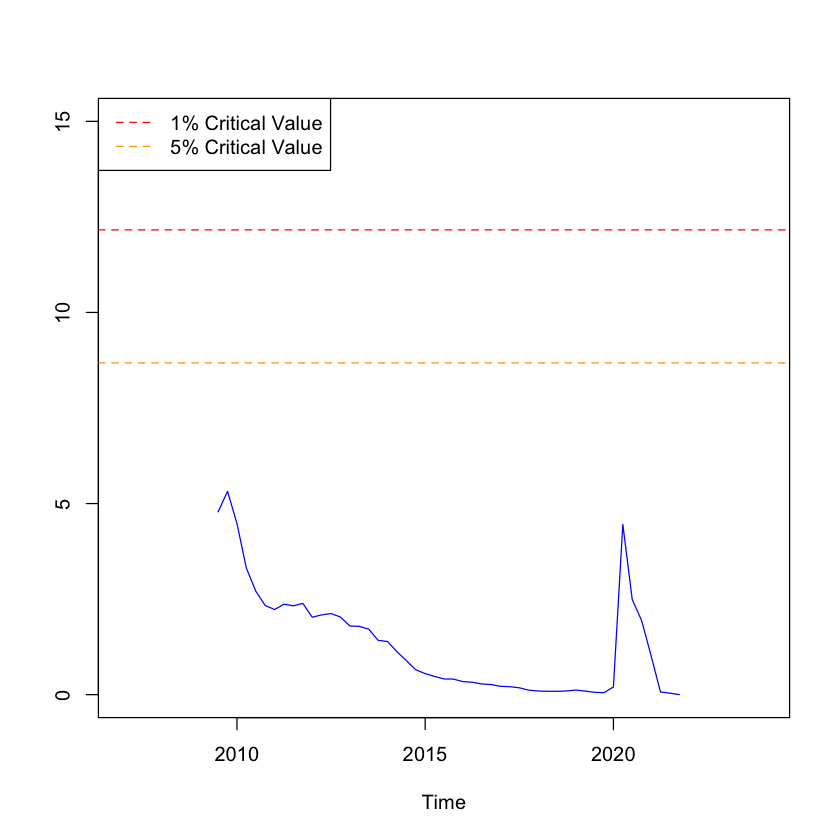

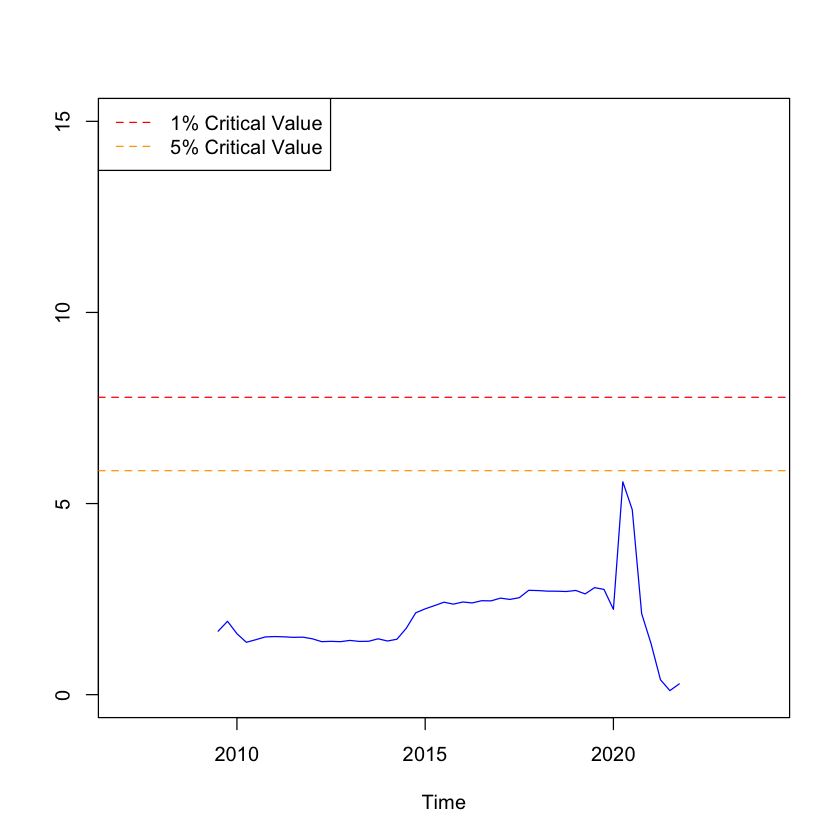

In [41]:
series_break_con_int <- ts(Fstats_break_con_int, 
                           start = tau[1],
                           end = tau[length(tau)],
                           frequency = 4)
plot(series_break_con_int, 
     xlim = c(2007, 2024), 
     ylim = c(0, 15), 
     col = "blue", 
     ylab = "")
abline(h = 8.68, lty = 2, col = "orange")
abline(h = 12.16, lty = 2, col = "red")
legend("topleft", 
       lty = c(2,2),
       col = c("red", "orange"),
       legend = c("1% Critical Value", "5% Critical Value"))

series_break_con_ar1 <- ts(Fstats_break_con_ar1,
                           start = tau[1],
                           end = tau[length(tau)],
                           frequency = 4)
plot(series_break_con_ar1,
     xlim = c(2007, 2024),
     ylim = c(0, 15),
     col = "blue",
     ylab = "")
abline(h = 5.86, lty = 2, col = "orange")
abline(h = 7.78, lty = 2, col = "red")
legend("topleft", 
       lty = c(2,2),
       col = c("red", "orange"),
       legend = c("1% Critical Value", "5% Critical Value"))


We can now turn to testing for a break in income in the same way, using an AR(3) model:

[1] 25.56713

[1] "2021 Q2"

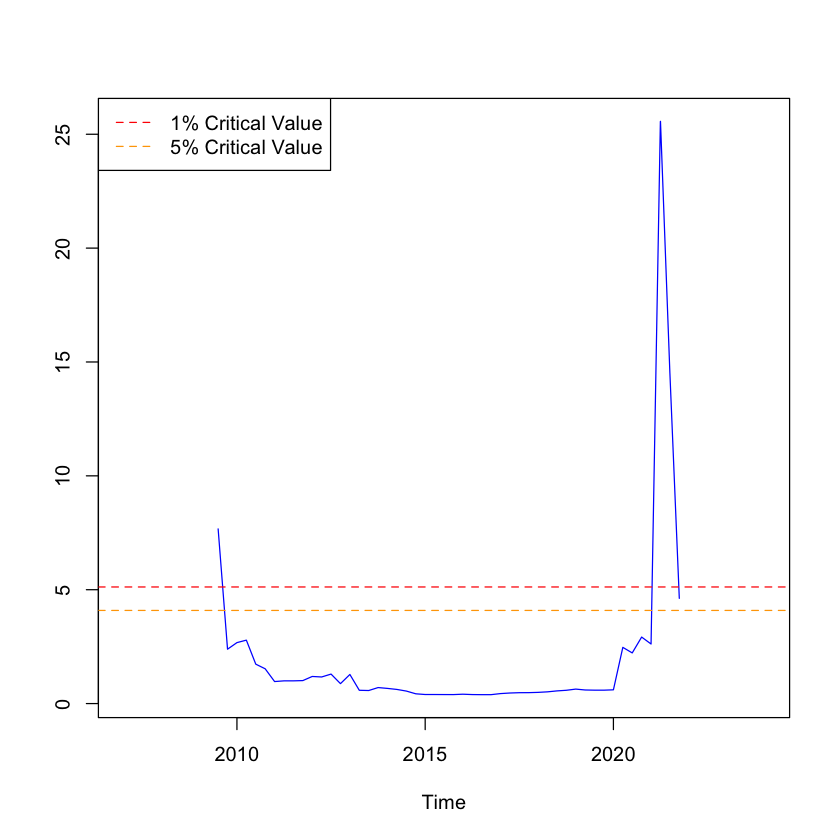

In [42]:
# QLR test for income AR3 model
for (i in 1:length(tau)) {
  
  D <- time(inc_diff) > tau[i]
  
  breaktest <- dynlm(ts(inc_diff) ~ L(ts(inc_diff)) + L(ts(inc_diff), 2) + L(ts(inc_diff), 3) + 
                       D*L(ts(inc_diff)) + D*L(ts(inc_diff), 2) + D*L(ts(inc_diff), 3))
  
  Fstats_break_inc[i] <- linearHypothesis(breaktest,
                                        c("DTRUE=0",
                                          "L(ts(inc_diff)):DTRUE",
                                          "L(ts(inc_diff), 2):DTRUE",
                                          "L(ts(inc_diff), 3):DTRUE"),
                                        vcov. = sandwich)$F[2]
}

QLR_inc <- max(Fstats_break_inc)
QLR_inc
as.yearqtr(tau[which.max(Fstats_break_inc)]) # 2021 Q2

series_break_inc <- ts(Fstats_break_inc,
                       start = tau[1],
                       end = tau[length(tau)],
                       frequency = 4)
plot(series_break_inc,
     xlim = c(2007, 2024),
     col = "blue",
     ylab = "")
abline(h = 4.09, lty = 2, col = "orange")
abline(h = 5.12, lty = 2, col = "red")
legend("topleft", 
       lty = c(2,2),
       col = c("red", "orange"),
       legend = c("1% Critical Value", "5% Critical Value"))


The critical values for a QLR test with a 15% trimming parameter with four restrictions are 4.09 at the 5% level, and 5.12 at the 1% level. This means that there is overwhelming support for a structural break within income changes, and we reject the null hypothesis of no structural break at the 1% level. This makes sense as the COVID-19 pandemic led to a massive increase in the volatility of income. In the USA, there were three rounds of stimulus payments made to consumers in order to help offset the effects of the pandemic. These came in 2020 Q2 and Q4, and then again in 2021 Q2, with almost half of the total amount paid occuring in 2021 (https://www.pandemicoversight.gov/data-interactive-tools/data-stories/update-three-rounds-stimulus-checks-see-how-many-went-out-and). These lump-sum payments meant that consumers had massive increases (and subsequent decreases) to their quarterly income roughly every other quarter. Because there is little post-pandemic data, we will instead choose to focus on the period before the pandemic in our subsequent analysis. Re-running a QLR test excluding data after 2021 Q1 results in the following:

[1] 8.55

[1] 48.45

              [,1]
2009 Q1 -0.3157839

            [,1]
2018 Q4 3.792671

[1] 14.67564

[1] "2009 Q1"

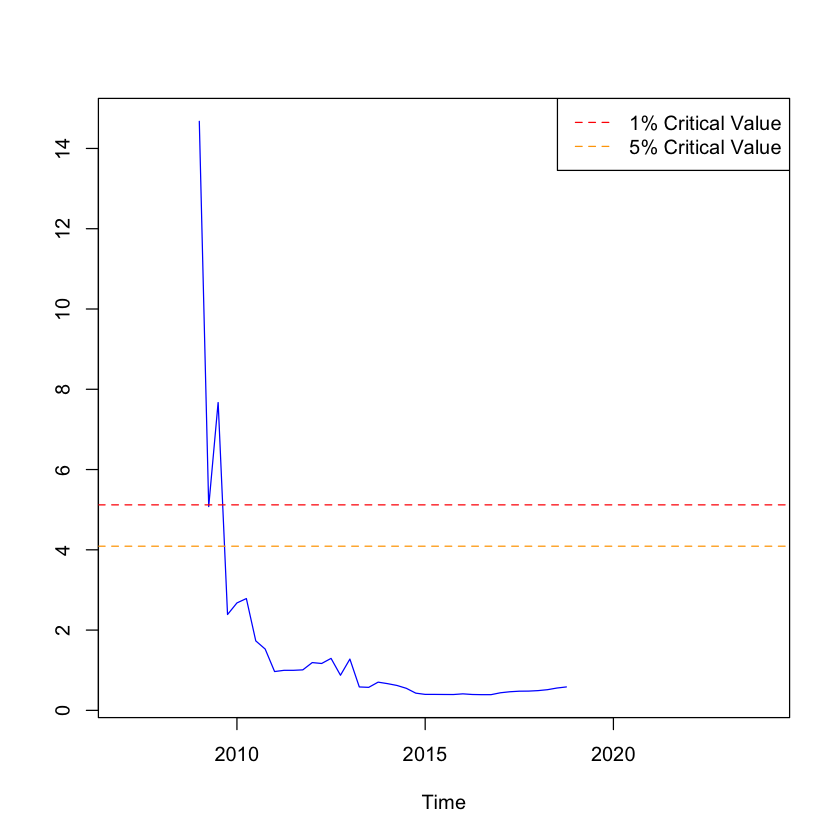

In [43]:
# Rerun QLR test on period before 2021 Q2
0.15 * length(inc_diff["2007/2021-1"]) # 8.55
0.85 * length(inc_diff["2007/2021-1"]) # 48.45

inc_diff[9] # 2009 Q1
inc_diff[48] # 2018 Q4

tau2 <- seq(2009.00, 2018.75, 0.25)

Fstats_break_inc2 <- numeric(length(tau2))

for (i in 1:length(tau2)) {
  
  D <- time(inc_diff) > tau2[i]
  
  breaktest <- dynlm(ts(inc_diff) ~ L(ts(inc_diff)) + L(ts(inc_diff), 2) + L(ts(inc_diff), 3) + 
                       D*L(ts(inc_diff)) + D*L(ts(inc_diff), 2) + D*L(ts(inc_diff), 3))
  
  Fstats_break_inc2[i] <- linearHypothesis(breaktest,
                                          c("DTRUE=0",
                                            "L(ts(inc_diff)):DTRUE",
                                            "L(ts(inc_diff), 2):DTRUE",
                                            "L(ts(inc_diff), 3):DTRUE"),
                                          vcov. = sandwich)$F[2]
}

QLR_inc2 <- max(Fstats_break_inc2)
QLR_inc2
as.yearqtr(tau2[which.max(Fstats_break_inc2)]) # 2009 Q1

series_break_inc2 <- ts(Fstats_break_inc2,
                       start = tau2[1],
                       end = tau2[length(tau2)],
                       frequency = 4)
plot(series_break_inc2,
     xlim = c(2007, 2024),
     col = "blue",
     ylab = "")
abline(h = 4.09, lty = 2, col = "orange")
abline(h = 5.12, lty = 2, col = "red")
legend("topright", 
       lty = c(2,2),
       col = c("red", "orange"),
       legend = c("1% Critical Value", "5% Critical Value"))


We now find significant evidence for a break during the Great Recession, which means that both of our predictions were correct with respect to the time series on income. We carry out one final QLR test to ensure that we now have a central stable epoch between these two crises. In the process, we also create a new `xts` object '`income_sub`' so that we can forecast using this period.

[1] 7.2

[1] 40.8

            [,1]
2010 Q4 1.509781

              [,1]
2019 Q2 -0.2909412

[1] 1.294852

[1] "2012 Q3"

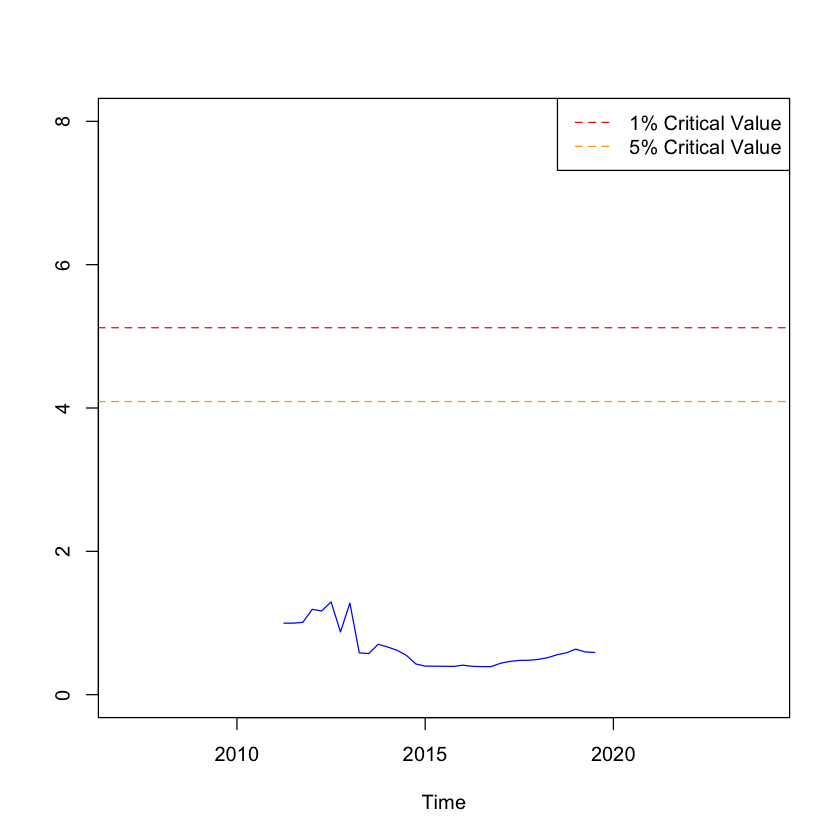

In [44]:
# Rerun QLR excluding data before 2009 Q2
income_sub <- inc_diff["2009-3/2021-1"]
0.15 * length(income_sub) # 7.2
0.85 * length(income_sub) # 40.8

income_sub[7] # 2011 Q2
income_sub[41] # 2019 Q3

tau3 <- seq(2011.25, 2019.50, 0.25)

Fstats_break_inc3 <- numeric(length(tau3))

for (i in 1:length(tau3)) {
  
  D <- time(inc_diff) > tau3[i]
  
  breaktest <- dynlm(ts(inc_diff) ~ L(ts(inc_diff)) + L(ts(inc_diff), 2) + L(ts(inc_diff), 3) + 
                       D*L(ts(inc_diff)) + D*L(ts(inc_diff), 2) + D*L(ts(inc_diff), 3))
  
  Fstats_break_inc3[i] <- linearHypothesis(breaktest,
                                           c("DTRUE=0",
                                             "L(ts(inc_diff)):DTRUE",
                                             "L(ts(inc_diff), 2):DTRUE",
                                             "L(ts(inc_diff), 3):DTRUE"),
                                           vcov. = sandwich)$F[2]
}

QLR_inc3 <- max(Fstats_break_inc3)
QLR_inc3
as.yearqtr(tau3[which.max(Fstats_break_inc3)]) # 2010 Q4

series_break_inc3 <- ts(Fstats_break_inc3,
                        start = tau3[1],
                        end = tau3[length(tau3)],
                        frequency = 4)
plot(series_break_inc3,
     xlim = c(2007, 2024),
     ylim = c(0, 8),
     col = "blue",
     ylab = "")
abline(h = 4.09, lty = 2, col = "orange")
abline(h = 5.12, lty = 2, col = "red")
legend("topright", 
       lty = c(2, 2),
       col = c("red", "orange"),
       legend = c("1% Critical Value", "5% Critical Value"))


Here, we find no evidence for structural breaks, which means that we can continue our analysis using this central period.

## Forecasting

Now that we are working with a new range of dates, we run a quick check to ensure that we are still using the best lag order for our models:

In [45]:

# Re-check lag length using stable epoch income_sub
IC_inc <- sapply(1:10, function(x)
  "AR" = IC(dynlm(ts(income_sub) ~ L(ts(income_sub), 1:x))))
stargazer(IC_inc, type = "text", title = "Inc AR Check")

IC_inc_adl <- sapply(1:10, function(x)
  "ADL" = IC(dynlm(ts(income_sub) ~ L(ts(income_sub),1:x) + L(ts(con_diff),1:x))))
stargazer(IC_inc_adl, type = "text", title = "Inc ADL Check")

# Re-check whether consumption Granger-causes income
granger_inc <- sapply(1:10, function(x)
  "GT" = Granger(dynlm(ts(income_sub) ~ L(ts(income_sub),1:x) + L(ts(con_diff),1:x))))
stargazer(granger_inc, type = "text", title = "Inc Granger Check")



Inc AR Check
p           1     2     3     4     5     6     7     8     9    10  
SER*      4.354 4.115 3.949 3.984 4.014 4.065 4.110 4.165 4.220 4.291
AIC       4.396 4.178 4.033 4.090 4.143 4.216 4.283 4.360 4.436 4.528
BIC       4.474 4.297 4.194 4.293 4.389 4.506 4.617 4.740 4.863 5.002
| t stat| 2.508 3.613 2.929 0.254 0.306 0.354 0.673 0.187 0.525 0.081
---------------------------------------------------------------------

Inc ADL Check
p           2     4     6     8    10    12    14    16    18    20  
SER*      4.359 4.124 3.974 3.973 4.029 4.023 4.127 4.036 4.160 4.304
AIC       4.423 4.228 4.119 4.157 4.249 4.276 4.407 4.335 4.467 4.601
BIC       4.542 4.429 4.403 4.526 4.704 4.819 5.040 5.061 5.286 5.515
| t stat| 0.939 0.032 0.714 1.493 0.017 1.614 0.327 2.223 0.148 0.541
---------------------------------------------------------------------

Inc Granger Check
p         1     2     3     4     5     6     7     8     9    10  
F       1.171 0.899 0.620 0.886 0.977 1.331 

Here we find that our initial investigations were correct - that changes in income are best forecast using an AR(3) model, and ICs select an ADL(3,3) model. However, this time, we do not find evidence for Granger Causality. We can no construct these models, and compare them.

In [46]:
# Model using dynlm
inc_ar3 <- dynlm(ts(income_sub) ~ L(ts(income_sub),1:3))
inc_adl <- dynlm(ts(income_sub) ~ L(ts(income_sub),1:3) + L(ts(con_diff),1:3))

names(inc_ar3$coefficients) <- c("(Intercept)",
                                 "Income Lag 1",
                                 "Income Lag 2",
                                 "Income Lag 3")

names(inc_adl$coefficients) <- c("(Intercept)",
                                 "Income Lag 1",
                                 "Income Lag 2",
                                 "Income Lag 3",
                                 "Consumpt Lag 1",
                                 "Consumpt Lag 2",
                                 "Consumpt Lag 3")

stargazer(inc_ar3, inc_adl, type = "text")



                                Dependent variable:             
                    --------------------------------------------
                                   ts(income_sub)               
                             (1)                    (2)         
----------------------------------------------------------------
Income Lag 1              -0.531***              -0.551***      
                           (0.166)                (0.174)       
                                                                
Income Lag 2               -0.399**              -0.424**       
                           (0.182)                (0.193)       
                                                                
Income Lag 3               0.555***              0.547***       
                           (0.189)                (0.196)       
                                                                
Consumpt Lag 1                                     1.192        
                        

Here, an AR(3) model will have better forecasting performance and we can see that none of the coefficients on lags of consumption are statistically significant. Plotting ACFs for the residuals of both models further supports modelling changes in income with an AR(3) model.

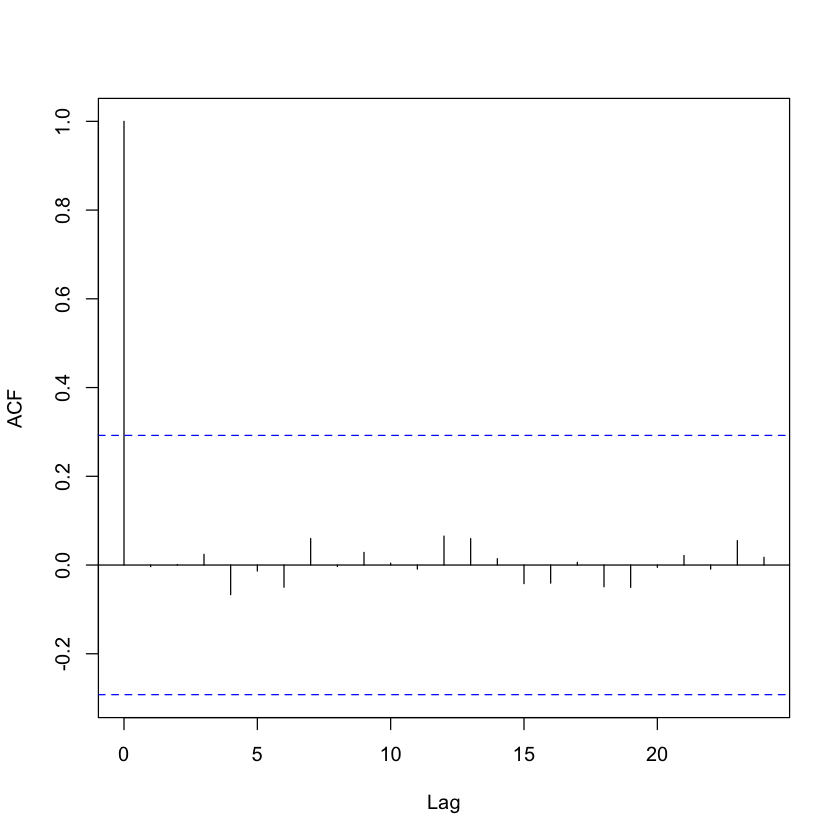

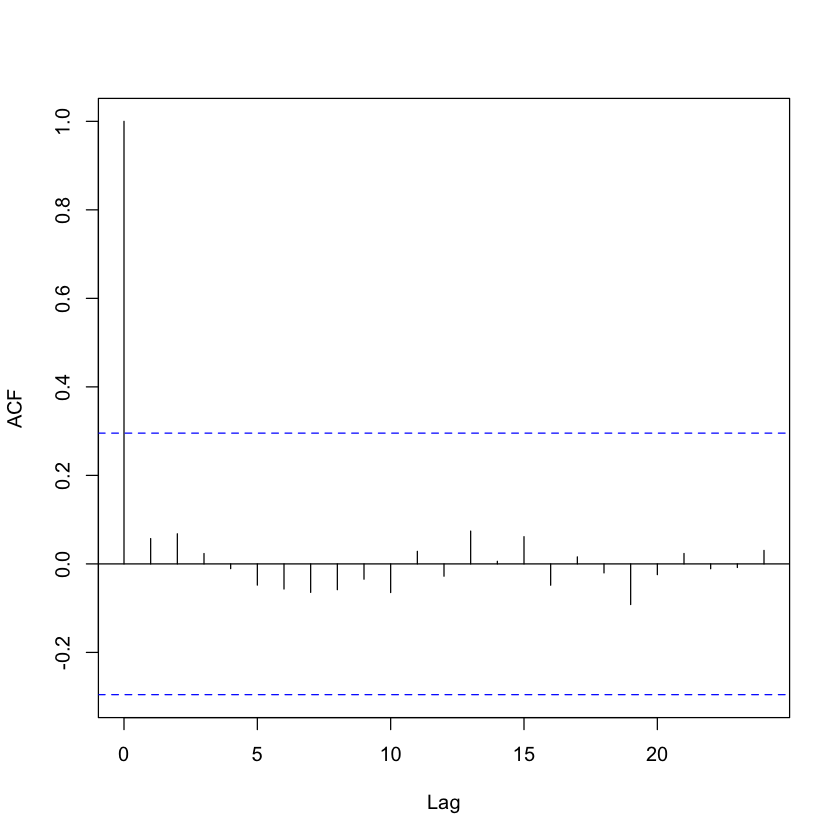

In [47]:
# Check residuals
acf(inc_ar3$residuals, lag.max = 24, plot = TRUE, main = "")
acf(inc_adl$residuals, lag.max = 24, plot = TRUE, main = "")

Although we used the `dynlm` function to create our AR(3) model, we could also use an AR specific function `ar.ols` or an as an ARIMA model without a moving average as shown below:

In [48]:
# Alternative modelling using ar.ols
ar.ols(income_sub,
       order.max = 10,
       aic = TRUE,
       demean = FALSE,
       intercept = TRUE)

# Using arima
arima(income_sub, order = c(3, 0, 0), method = "CSS") # Conditional sum-of-squares so model is same



Call:
ar.ols(x = income_sub, aic = TRUE, order.max = 10, demean = FALSE,     intercept = TRUE)

Coefficients:
      1        2        3  
-0.5306  -0.3991   0.5548  

Intercept: 4.389 (1.508) 

Order selected 3  sigma^2 estimated as  47.25


Call:
arima(x = income_sub, order = c(3, 0, 0), method = "CSS")

Coefficients:
          ar1      ar2     ar3  intercept
      -0.5306  -0.3991  0.5548     3.1925
s.e.   0.1535   0.1680  0.1751     0.7294

sigma^2 estimated as 47.25:  part log likelihood = -160.64

The `arima` function is also useful when used in combination with the `forecast` function, and we can use them both together to visualise forecasts for the COVID-19 period in a fan-chart:

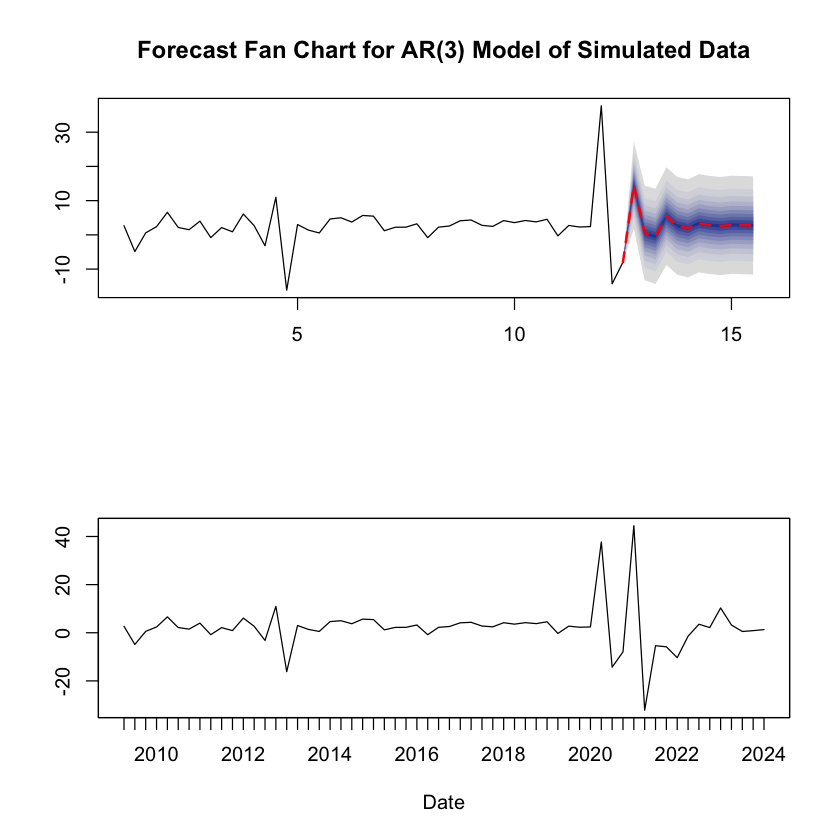

In [49]:
# Compute forecasts and prediction intervals for the next 12 periods
inc_arima <- arima(income_sub["2009/2020"], order = c(3, 0, 0), method = "CSS")
fc <- forecast(inc_arima, h = 12, level = seq(5, 99, 10))

# Plot fan chart and compare
par(mfrow = c(2,1))

plot(fc, 
     main = "Forecast Fan Chart for AR(3) Model of Simulated Data",
     showgap = F, 
     fcol = "red",
     flty = 2)

plot(as.zoo(inc_diff["2009-3/2024-1"]),
     ylab = "",
     xlab = "Date")


## Cointegration

Finally, we return to the topic of cointegration which was discussed previously. As both series are I(1) and the PIH predicts that they will have a cointegrating relationship, it is important to investigate whether this is the case. To conduct a test for cointegration, we first need to regress changes in consumption on changes in income in order to estimate their cointegrating coefficient, $\theta$. We then test for stationarity in the residuals of the regression by performing an ADF test using adjusted Engle-Granger critical values. If we reject the null hypothesis of stationarity, we conclude that that consumption and income are cointegrated.


Call:
lm(formula = log(consumpt) ~ log(income))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.189201 -0.012649  0.004291  0.012247  0.056488 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.09501    0.34063   3.215    0.002 ** 
log(income)  0.87480    0.03563  24.551   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03583 on 68 degrees of freedom
Multiple R-squared:  0.8986,	Adjusted R-squared:  0.8971 
F-statistic: 602.8 on 1 and 68 DF,  p-value: < 2.2e-16



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -2.7804 3.9064 


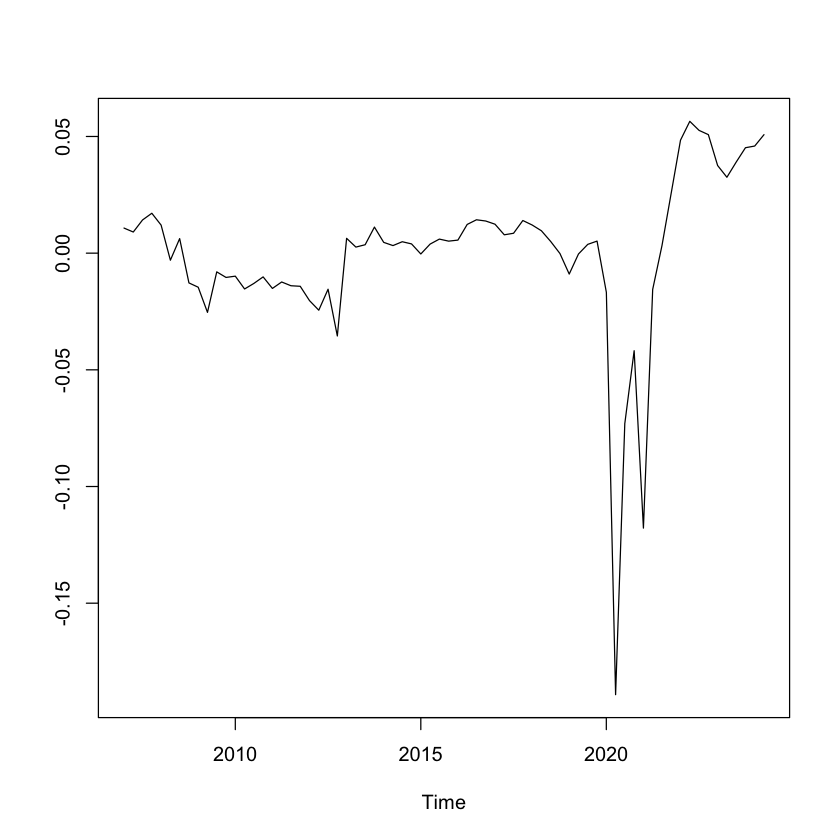

In [50]:
# Estimate cointegrating relationship
coin_model <- lm(log(consumpt) ~ log(income))
summary(coin_model) # int = 1.0950, theta-hat = 0.8748

# Test for stationarity in residuals
coin_res <- ts(coin_model$residuals, start = 2007, end = 2024.25, frequency = 4)

par(mfrow = c(1,1))
plot(coin_res,
     ylab = "")

ur.df(coin_res, 
      type = "drift",
      lags = 6,
      selectlags = "BIC")

The adjusted Engle-Granger critical values are:

|10% | 5% | 1%|
|-|-|-|
|-3.12 | -3.41 | -3.96|

Therefore, we fail to reject the null hypothesis of the presence of a stochastic  at the 10% level. Additionally, by plotting the residuals, we see little evidence of stationarity but there definitely seems to be a change in the mean and variance after the COVID-19 pandemic. As we have already previously tested for a structural break in this period, we re-estimate the cointegrating relationship pre-COVID.


Call:
lm(formula = log(consumpt["2007/2020"]) ~ log(income["2007/2020"]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.156714 -0.014161  0.006383  0.016780  0.029111 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                2.1029     0.3702    5.68 5.53e-07 ***
log(income["2007/2020"])   0.7682     0.0389   19.75  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02812 on 54 degrees of freedom
Multiple R-squared:  0.8784,	Adjusted R-squared:  0.8762 
F-statistic: 390.1 on 1 and 54 DF,  p-value: < 2.2e-16



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -3.2079 5.1562 


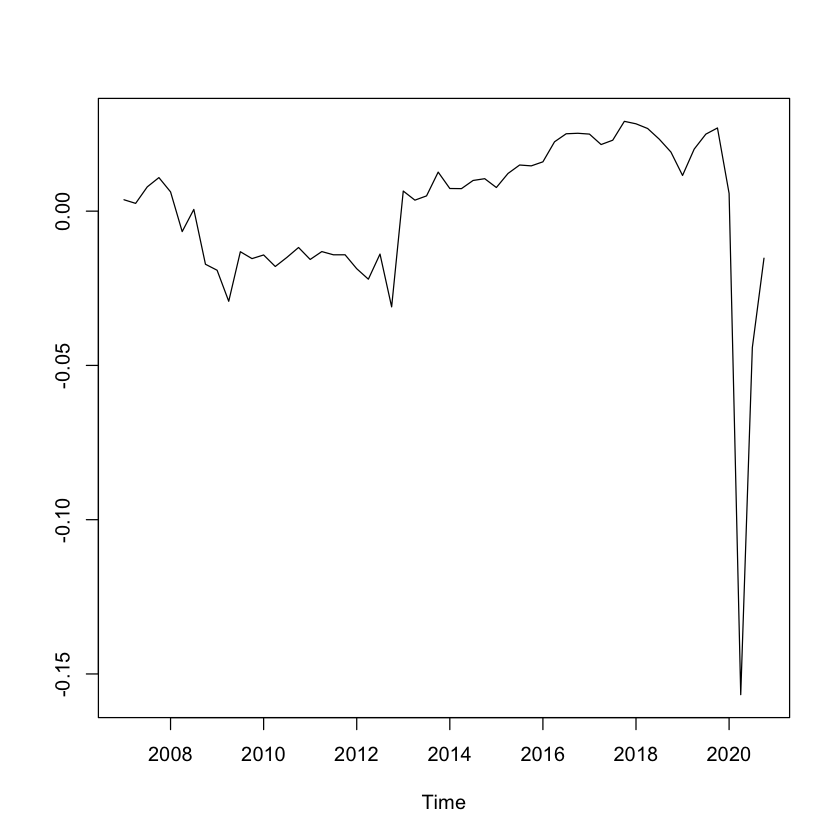

In [51]:
# Re-estimate and test up to 2020
coin_model2 <- lm(log(consumpt["2007/2020"]) ~ log(income["2007/2020"]))
summary(coin_model2)

coin_res2 <- ts(coin_model2$residuals, start = 2007, end = 2020.75, frequency = 4)

par(mfrow = c(1,1))
plot(coin_res2,
     ylab = "")

ur.df(coin_res2, 
      type = "drift",
      lags = 6,
      selectlags = "BIC")


We now reject the null hypothesis of a unit root at the 10% level, which means that we find some evidence for cointegration between consumption and income. This coincides with the predictions of the PIH, but this is certainly fragile evidence and it is difficult to confirm a long-run equilibrium with such a small number of observations. Nevertheless, we have succeeded in carrying out successful investigation into the PIH through time series analysis, using original code written in R

## Conclusion

In this project, we have become more familiar with the fundamentals of time series analysis using R, and tested several aspects of the PIH:
1. We found little evidence that temporary changes to income Granger-causes consumption, which aligns with the PIH as consumption should be determined by expectations over permanent income. We also found evidence that, when viewed under the lens of AR and ADL models, changes to consumption are best modelled using an intercept-only model. This implies that changes to consumption remains fairly constant

2. We also failed to find evidence supporting structural breaks within consumption, meaning that changes in consumption seems to remain fairly robust to short-lived crises that do not substantially affect permanent-income.
    - We also found evidence for structural breaks to income changes during the COVID-19 period and the Great Recession, which we expected

3. We also performed a test for cointegration between income and consumption, which we found some weak evidence for at the 10% level. This suggests a long-run relationship and common stochastic trend, which aligns with the PIH. However, this relationship may be better explored with a longer time series

## Bibliography



- Bromley-Davenport, C. (2021). Covid and the Permanent Income Hypothesis [Online]. Adam Smith Institute. Available at: https://www.adamsmith.org/blog/covid-and-the-permanent-income-hypothesis 

- Clower, E. (2020). A guide to conducting cointegration tests [Online]. Aptech Systems. Available at: https://www.aptech.com/blog/a-guide-to-conducting-cointegration-tests/

- Colonescu, C. (2016). Principles of Econometrics with R. Available at: https://bookdown.org/ccolonescu/RPoE4/ 

- Duffy, J.A. (2022). Time Series [PowerPoint Presentation]. Quantitative Economics. Department of Economics. University of Oxford.

- Hanck, C., Arnold, M., Gerber, A., and Schmelzer, M. (2021). Introduction to Econometrics with R [Online]. University of Duisburg-Essen. Available at: https://www.econometrics-with-r.org/index.html 

- Phillips, N. (2018). YaRrr! The Pirate’s Guide to R [Online]. Available at: https://bookdown.org/ndphillips/YaRrr/ 

- Stock, J. and Watson, M. (2020). Introduction to Econometrics, Fourth Edition. Pearson Education Limited.

- U.S. Bureau of Economic Analysis. Real Disposable Personal Income [DSPIC96]. retrieved from FRED, Federal Reserve Bank of St Louis. Available at: https://fred.stlouisfed.org/series/DSPIC96 

- U.S. Bureau of Economic Analysis. Real Personal Consumption Expenditures [PCEC96]. retrieved from FRED, Federal Reserve Bank of St Louis. Available at: https://fred.stlouisfed.org/series/PCEC96

- Yu, W. (2019). Time Series Modelling with ARIMA in R [Online]. Community contributions for EDAV Fall 2019. Available at: https://jtr13.github.io/cc19/time-series-modeling-with-arima-in-r.html 